# Inference showcase

This notebooks shows how a pretrained ML model can be applied to a larger dataset of one month.

## Initial Configuration

### Import modules

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### set device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Set device to {device}.")

Set device to cpu.


### set paths

In [3]:
grid_file = '/hpc/uwork/fe11bacy/invar_new/invar_0027_R03B08_L120_20231113_tiles.grb'
fg_path = '/hpc/uwork/tdeppisc/AIDA_data/ICON-EU'
synop_path = '/hpc/uwork/tdeppisc/AIDA_data/SYNOP'
output_path = 'showcase_output'

### define inference time interval

In [4]:
from util import TimeSeries
valid_times = TimeSeries(
        start='20230101000000',
        end='20230131230000',
        step={'hours':3})

### set domain boundaries

In [5]:
domain = {'lon_min': 7.5, 'lon_max': 9.5, 'lat_min': 49.5, 'lat_max': 51.5}

## How to load a model  

### load a pre-trained model

The following AIDA model has been pre-trained for educational purposes. It uses a graph neural network architecture and can produce realistic results for the small model domain under study.

In [6]:
filename = "/hpc/uwork/tdeppisc/AIDA_data/models/gnn_example.pt"
model = torch.load(filename,map_location=torch.device(device), weights_only=False)

print(model)

DAGraphNN(
  (forward_op): ModuleDict(
    (SYNOP): InSituFO()
  )
  (norm): Normalizer()
  (fg_embedding): MLP(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (meta_embedding): MLP(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (obs_embedding): ModuleDict(
    (SYNOP): MLP(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): ReLU()
    )
  )
  (encoder): MLP(
    (0): Linear(in_features=48, out_features=16, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (edge_attr_embedding): MLP(
    (0): Linear(in_features=

## How to load data

The process of data loading is of course similar to the training notebook.  We hence skip over that. (Data loading may take around two minutes.)

In [7]:
from observations import ObservationDataset

obs = ObservationDataset(valid_times=valid_times, domain=domain)
obs.add_feedback_data(path=synop_path,
                      obs_type='SYNOP', fdbk_type='mon',
                      model='ICON-EU', n_obs=50,
                      observation_descriptions =
                      [{"varno": 39, "obs_err": .5}])
print(obs)

Read feedback files of type monSYNOP from /hpc/uwork/tdeppisc/AIDA_data/SYNOP.
Data loading took 21.87s.
ObservationDataset
  - validity times: TimeSeries: 248 time steps from 20230101000000 until 20230131210000
  - sample data for 20230101000000:
    ObservationCollection, contains 1 observational type(s):
      - SYNOP:
        SynopObservationData
         - values tensor: torch.Size([50, 5])
         - columns: ['obs', 'obs_err', 'varno', 'lon', 'lat']
         - complete: True


In [8]:
from forecasts import ForecastDataset
fg = ForecastDataset(valid_times=valid_times)
fg.add_analysis_grid(grid_file=grid_file,
                     model="ICON-EU",
                     static_field_descriptions={'CLON':0, 'CLAT':0},
                     domain=domain,
                     grid_3d=False,
                     interpolation_method='inv_distances')
fg.add_ICON_fg(model="ICON-EU",
               layer_descriptions={'T_2M':2},
               path=fg_path,
               use_index_file=True)
print(fg)

Create GridInformation from /hpc/uwork/fe11bacy/invar_new/invar_0027_R03B08_L120_20231113_tiles.grb

Read [['T_2M', 2]] from ICON first guess data.

Data loading took 346.07s.
ForecastDataset
  - validity times: TimeSeries: 248 time steps from 20230101000000 until 20230131210000
  - analysis grid:
    UnstructuredGrid
      - coordinates for 700 grid points
      - heights for 1 layers
      - interpolation method: inv_distances
      - static fields:
        ForecastData
          - values tensor: torch.Size([2, 700])
          - layers: [['CLON', 0], ['CLAT', 0]]
          - complete: True
  - sample data for 20230101000000:
    ForecastData
      - values tensor: torch.Size([1, 700])
      - layers: [['T_2M', 2]]
      - complete: True


In [9]:
from datasets import DADataset
dataset = DADataset(obs, fg, return_graph_data=True)

## Apply the model to data  

The `DAInference` class applies the ML model to a dataset.

In [10]:
from inference import DAInference
inference = DAInference(model, dataset)

The `DAInference` class provides 'getter' functions for convenient extraction of the desired data. Here are some examples:

In [11]:
print('observations:')
print(inference.get_obs_data('obs','20230115120000','SYNOP'))

print('\nfirst guess in observation space')
print(inference.get_obs_data('h_fg','20230115120000','SYNOP'))

print('\nanalysis in observation space with coordinates')
print(inference.get_obs_data('h_an','20230115120000','SYNOP', return_coordinates=True))

observations:
tensor([277.4500, 277.3500, 276.7500, 276.9500, 278.2500, 276.8500, 277.3500,
        277.5500, 275.5500, 280.0500, 278.5500, 277.2500, 280.2500, 278.3500,
        277.5500, 279.7500, 280.2500, 276.2500, 279.7500, 279.8500, 280.7500,
        278.7500, 280.2500, 279.6500, 279.1500, 279.0500, 278.5500, 277.6500,
        277.5500, 279.3500, 277.1500, 277.8500, 279.0500, 279.6500, 278.7500,
        278.3500, 276.9500, 278.7500, 275.8500, 278.1500, 279.6500, 276.5500,
        277.0500, 277.9500, 278.6500, 278.3500, 275.0500, 277.2500, 278.2500,
        278.7500])

first guess in observation space
tensor([278.7589, 277.2762, 277.1623, 277.2670, 278.8376, 277.4095, 277.5911,
        278.4591, 276.9959, 279.8376, 279.4151, 279.9730, 279.9047, 278.9943,
        278.1223, 279.7135, 279.2152, 277.0758, 278.6367, 279.4074, 279.9615,
        279.3954, 279.8989, 279.7044, 279.4576, 279.4778, 280.1487, 278.9857,
        280.1825, 279.6527, 279.8272, 278.3954, 279.2226, 279.7656, 279.516

In [12]:
print('first guess with coordinates')
print(inference.get_fc_data('fg','20230115120000',['T_2M',2],return_coordinates=True))

print('\nanalysis:')
print(inference.get_fc_data('an','20230115120000',['T_2M',2]))

first guess with coordinates
(array([8.58019447, 8.66222572, 8.72667885, 8.80675697, 8.96300697,
       8.8712101 , 8.95324135, 9.01769447, 8.49035072, 8.40050697,
       8.48253822, 8.54503822, 8.31066322, 8.2227726 , 8.30285072,
       8.36730385, 8.44738197, 8.53722572, 8.4571476 , 8.39269447,
       8.60167885, 8.5118351 , 8.59191322, 8.65636635, 8.73644447,
       8.82628822, 8.7462101 , 8.68175697, 8.9180851 , 9.00792885,
       8.9258976 , 8.8633976 , 8.78136635, 8.6915226 , 8.77160072,
       8.83605385, 8.62706947, 8.71691322, 8.63488197, 8.57238197,
       9.07042885, 8.9805851 , 9.06261635, 9.12511635, 8.89074135,
       8.8008976 , 8.88097572, 8.94542885, 9.02550697, 9.11730385,
       9.0352726 , 8.97081947, 9.17980385, 9.08800697, 9.17003822,
       9.23253822, 9.31456947, 9.40636635, 9.3243351 , 9.2618351 ,
       9.4962101 , 9.44347572, 9.36144447, 9.2696476 , 9.35167885,
       9.41417885, 9.2071476 , 9.29894447, 9.21691322, 9.1524601 ,
       9.2540226 , 9.16222572, 9

## How to create statistics 

In [13]:
from obs_stats import ObservationStatistics
obs_stats = ObservationStatistics(inference)

The interface is meant to be used in scripts. Therefore all options are passed as a dictionary that can be saved in a configuration file.

In [14]:
# calculate observation error statistics for each time step in the dataset
my_stats = obs_stats.create_statistics([
        {"description": "2m temperature (o-b)",
         "obs_type": "SYNOP",
         "stat_type": "o-b",
         "stat_val" : "values",
         "filter": {"varno": 39}},
        {"description": "2m temperature (o-a)",
         "obs_type": "SYNOP",
         "stat_type": "o-a",
         "stat_val" : "values",
         "filter": {"varno": 39}}])

In [15]:
# uncomment the next line to see the statistics for each analysis step (large ouput!)
# print(my_stats[0])

Statistics can be aggregated over time. For instance to calculate global averages:

In [16]:
# aggregate statistics over complete time period
ob_total = my_stats[0].get_average('all')
oa_total = my_stats[1].get_average('all')

# print the aggregated statistics
print("global statistics")
print(ob_total)
print(oa_total)

global statistics
mean =    -0.16, std =     0.86 (n=     12400) 2m temperature (o-b)
mean =    -0.00, std =     0.18 (n=     12400) 2m temperature (o-a)


## How to plot statistics

Now we calculate an average for each day in the time period and plot bias and standard deviation.

Text(0.5, 0, 'days')

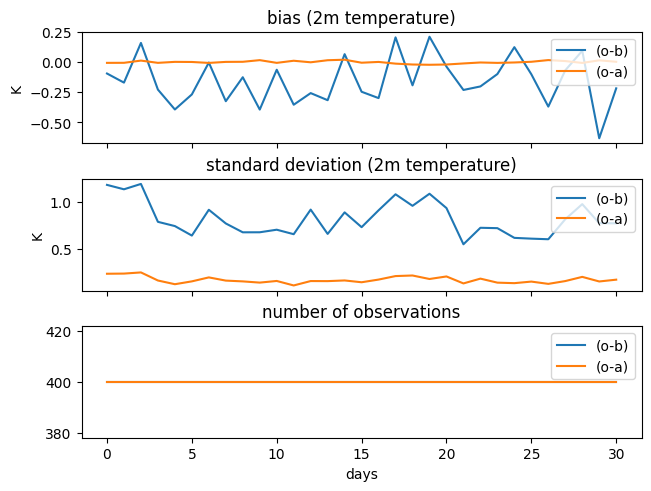

In [17]:
fig, axs = plt.subplots(3,1, sharex=True, constrained_layout=True)

# average statistics for each day
ob_daily = my_stats[0].get_average('years+months+days')
oa_daily = my_stats[1].get_average('years+months+days')

ax = axs[0]
ax.plot(ob_daily.mean, label="(o-b)")
ax.plot(oa_daily.mean, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('bias (2m temperature)')
ax.set_ylabel('K')

ax = axs[1]
ax.plot(ob_daily.std, label="(o-b)")
ax.plot(oa_daily.std, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('standard deviation (2m temperature)')
ax.set_ylabel('K')

ax = axs[2]
ax.plot(ob_daily.n_obs, label="(o-b)")
ax.plot(oa_daily.n_obs, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('number of observations')
ax.set_xlabel('days')

# bias diurnal cycle

Text(0.5, 0, 'analysis step')

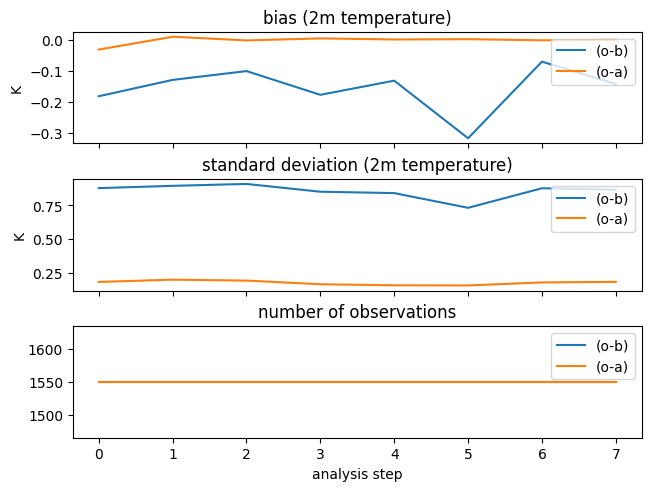

In [18]:
fig, axs = plt.subplots(3,1, sharex=True, constrained_layout=True)

# average statistics for each day
ob_daily = my_stats[0].get_average('hours')
oa_daily = my_stats[1].get_average('hours')

ax = axs[0]
ax.plot(ob_daily.mean, label="(o-b)")
ax.plot(oa_daily.mean, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('bias (2m temperature)')
ax.set_ylabel('K')

ax = axs[1]
ax.plot(ob_daily.std, label="(o-b)")
ax.plot(oa_daily.std, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('standard deviation (2m temperature)')
ax.set_ylabel('K')

ax = axs[2]
ax.plot(ob_daily.n_obs, label="(o-b)")
ax.plot(oa_daily.n_obs, label="(o-a)")
ax.legend(loc='upper right')
ax.set_title('number of observations')
ax.set_xlabel('analysis step')

## How to plot data for a given timestep

The `DAPlots` class establishes a simple interface from the `DAInference` class to the matplotlib library.

In [19]:
from plots import DAPlots
plotting = DAPlots()

### Select time step to be plotted

In [20]:
time_step = "20230110000000"

### Plot fields

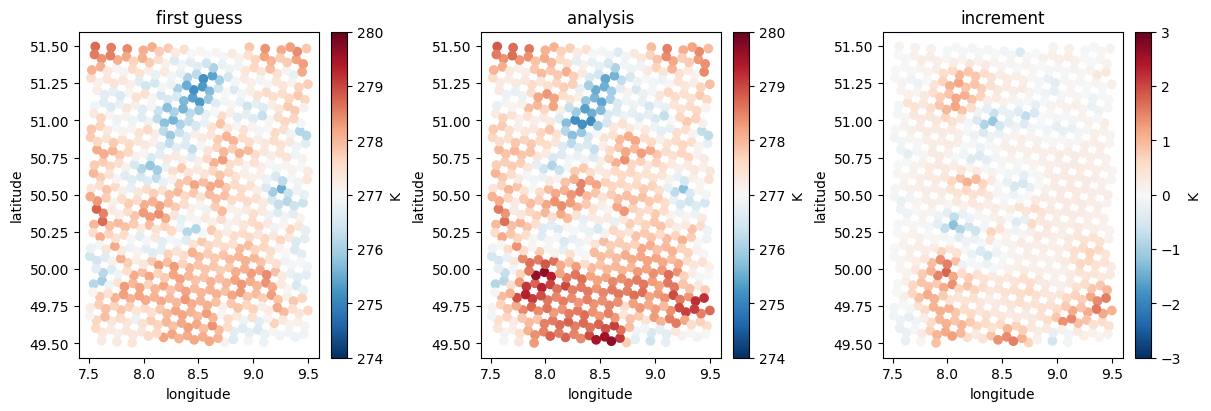

In [21]:
fig, axs = plt.subplots(1,3, figsize = (12,4),constrained_layout = True)

vmin=274.
vmax=280.

# plot fg
plot_description = {
     "plot_type" : "fg",
     "time_step" : time_step,
     "plot_style" : "scatter",
     "layer_description" : ["T_2M",2],
     "plot_settings" : {"cmap": "RdBu_r", "vmin": vmin, "vmax": vmax},
     "axis_settings" : {"title": "first guess", "xlabel": "longitude", "ylabel": "latitude"},#    "add_colorbar":False
}
plotting.infer_plots(axs[0], inference,plot_description)

# plot analysis
plot_description = {
    "plot_type" : "an",
    "time_step" : time_step,
    "plot_style" : "scatter",
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"cmap": "RdBu_r", "vmin": vmin, "vmax": vmax},
    "axis_settings" : {"title": "analysis", "xlabel": "longitude", "ylabel": "latitude"}
}
plotting.infer_plots(axs[1], inference,plot_description)

# plot increment
plot_description = {
    "plot_type" : "inc",
    "time_step" : time_step,
    "plot_style" : "scatter",
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"cmap": "RdBu_r", "vmin": -3., "vmax": 3.},
    "axis_settings" : {"title": "increment", "xlabel": "longitude", "ylabel": "latitude"}
}
plotting.infer_plots(axs[2], inference,plot_description)

### Plot observations

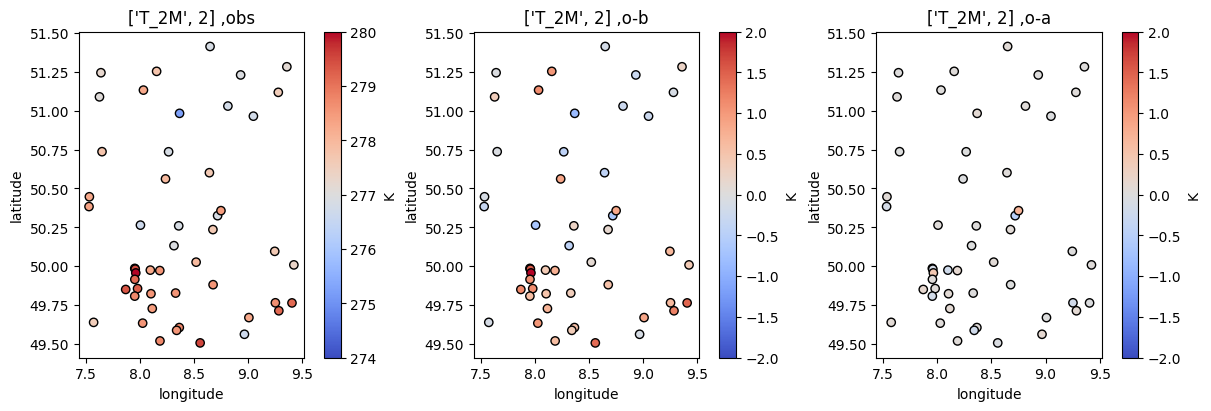

In [22]:
fig, axs = plt.subplots(1,3, figsize = (12,4), constrained_layout = True)

# options for a scatter plot of observations
plot_description = {
    "plot_type" : "obs",
    "time_step" : time_step,
    "plot_style" : "scatter",
    "obs_type" : "SYNOP",
    "filter" : {"varno" : 39},
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"edgecolor" : "black", "cmap" : "coolwarm", "vmin": vmin, "vmax": vmax}}
plotting.infer_plots(axs[0],inference, plot_description)

# change colorbar
plot_description["plot_settings"]["vmin"] = -2.
plot_description["plot_settings"]["vmax"] = 2.

# plot departures
plot_description["plot_type"] = "o-b"
plotting.infer_plots(axs[1],inference, plot_description)

plot_description["plot_type"] = "o-a"
plotting.infer_plots(axs[2],inference, plot_description)

### Plot Fields + observations

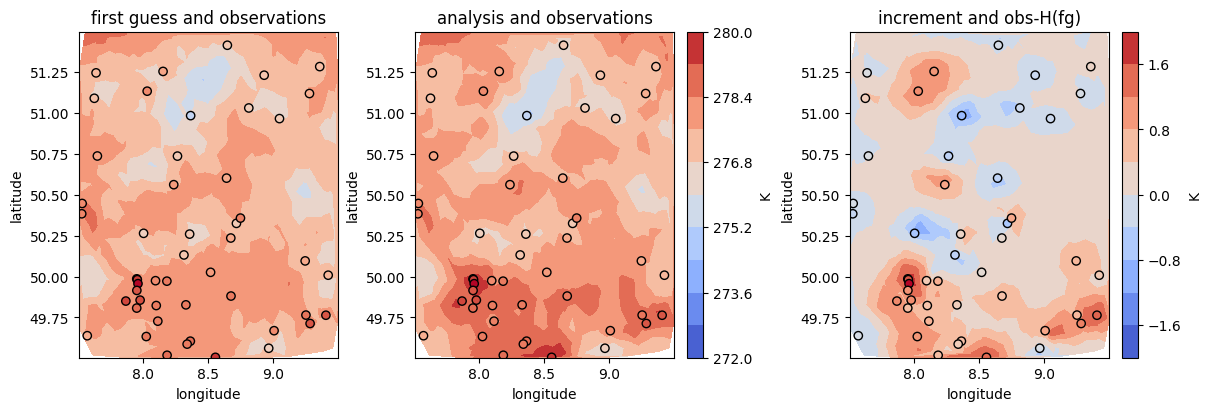

In [23]:
fig, axs = plt.subplots(1,3, figsize = (12,4),constrained_layout = True)

vmin=272
vmax=280
levels = list(np.linspace(vmin,vmax,11)) # for contour plots

# plot description for nwp model layer
plot_description = {
    "plot_type" : "fg",
    "time_step" : time_step,
    "plot_style" : "contourf",
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"levels": levels, "cmap" : "coolwarm"},
    "add_colorbar":False,
}

# plot description for observations
plot_description_2 = {
    "plot_type" : "obs",
    "time_step" : time_step,
    "plot_style" : "scatter",
    "obs_type" : "SYNOP",
    "filter" : {"varno" : 39},
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"edgecolor" : "black", "cmap" : "coolwarm", "vmin" : vmin, "vmax" : vmax},
    "axis_settings" : {"title" : "first guess and observations", "xlabel": "longitude", "ylabel": "latitude"},
    "add_colorbar": False,    
}

# call plotting functions
plotting.infer_plots(axs[0],inference, plot_description)
plotting.infer_plots(axs[0],inference, plot_description_2)

# plot description for nwp model layer
plot_description["plot_type"] = "an"
plot_description["add_colorbar"] = True

# plot description for observations
plot_description_2["axis_settings"]["title"] = "analysis and observations"

# call plotting functions
plotting.infer_plots(axs[1],inference, plot_description)
plotting.infer_plots(axs[1],inference, plot_description_2)

# plot increments and obs-H(fg)
vmin = -2.
vmax = 2.
levels = list(np.linspace(vmin,vmax,11))

plot_description = {
    "plot_type" : "inc",
    "time_step" : time_step,
    "plot_style" : "contourf",
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"levels": levels, "cmap" : "coolwarm", "vmin": vmin, "vmax": vmax},
    "add_colorbar" : True,
}

plot_description_2 = {
    "plot_type" : "o-b",
    "time_step" : time_step,
    "plot_style" : "scatter",
    "obs_type" : "SYNOP",
    "filter" : {"varno" : 39},
    "layer_description" : ["T_2M",2],
    "plot_settings" : {"edgecolor" : "black", "cmap" : "coolwarm", "vmin": vmin, "vmax": vmax},
    "axis_settings" : {"title": "increment and obs-H(fg)"},
    "add_colorbar" : False
}
plotting.infer_plots(axs[2],inference, plot_description)
plotting.infer_plots(axs[2],inference, plot_description_2)